### Instalando e importando bibliotecas

In [2]:
!pip install pyspark

In [67]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
spark = SparkSession.builder.appName("Logistic_Regression").getOrCreate()

### Carregando o arquivo csv de origem

In [ ]:
input_path="C:\\Users\\Vandinho\\Documents\\Tecnologia\\Pos_BigData\\8_Analise_Spark\\infnet_projeto_ml\\data"
dataset_file = "bank.csv"

In [40]:
df = spark.read.csv(f'{input_path}\\{dataset_file}', header = True, inferSchema = True)
df.show(10)

+---+----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|    admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|    admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41|technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|  services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|    admin.| married| tertiary|     no|    184|     no|  no|unkno

### Verificando o esquema dos dados inferido

In [41]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



### Tratamentos e análise exploratória

In [42]:
# Invertendo linhas com as colunas para melhor visualização das features
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [43]:
# Trazendo o resumo estatístico: 
# Count de linhas, media por coluna, desvio padrão, valor mínimo e máximo na coluna

features = [f[0] for f in df.dtypes if f[1] == 'int']
df.select(features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


In [44]:
# Eliminando colunas que não são tão relevantes para o modelo: day e month
cols_to_drop = ["day", "month"]
df = df.drop(*cols_to_drop)
cols = df.columns

df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



### Preparando o dataset para o processo de aprendizagem 

In [45]:
categ_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "poutcome"]
num_cols = ["age", "balance", "duration", "campaign", "pdays", "previous"]
stages = []

for col in categ_cols:
    stringIndexer = StringIndexer(inputCol = col, outputCol = f"{col}Index")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[f"{col}classVec"])
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = "deposit", outputCol = "label")
stages += [label_stringIdx]

assemblerInputs = [f"{c}classVec" for c in categ_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [46]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)

selectedCols = ["label", "features"] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [47]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1.0,1.0,1.0,1.0,1.0
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


### Divindo o dataset randomicamente em treinamento e teste

In [53]:
# Será dividido em 70% para treinamento e 30% para teste do modelo

train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Size: " + str(train.count()))
print("Test Dataset Size: " + str(test.count()))

Training Dataset Size: 7855
Test Dataset Size: 3307


### Instanciando o modelo e fazendo o treinamento com os 70% do dataset

In [60]:
lr = LogisticRegression(featuresCol = "features", labelCol = "label", maxIter=10)
lrModel = lr.fit(train)

### Obtendo os coeficientes Beta do modelo

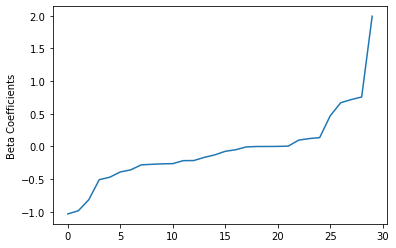

In [61]:
# Os coeficientes ficam armazenados como uma propriedade do objeto instanciado do modelo
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel("Beta Coefficients")
plt.show()

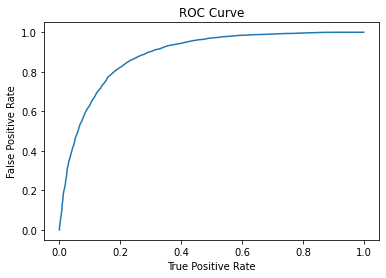

Training areaUnderROC: 0.8865478305561797


In [63]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])

plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print(f'Training areaUnderROC: {str(trainingSummary.areaUnderROC)}')

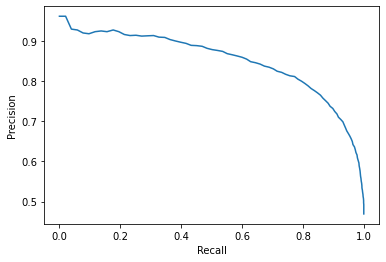

In [64]:
prec_rec = trainingSummary.pr.toPandas()
plt.plot(prec_rec['recall'], prec_rec['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### Fazendo previsões com os 30% do dataset separados para teste

In [66]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(15)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[1.93500470498078...|       0.0|[0.87380233100701...|
| 49|management|  0.0|[2.04809361205494...|       0.0|[0.88575484704982...|
| 52|management|  0.0|[-0.7002122133357...|       1.0|[0.33176517908283...|
| 53|management|  0.0|[1.03431610227355...|       0.0|[0.73775180622517...|
| 58|management|  0.0|[2.74273671692568...|       0.0|[0.93950183380104...|
| 32|management|  0.0|[1.25033004378243...|       0.0|[0.77735698810450...|
| 57|management|  0.0|[1.19540519867322...|       0.0|[0.76770638557283...|
| 52|management|  0.0|[3.26456982709638...|       0.0|[0.96319314409492...|
| 46|management|  0.0|[2.15036209979034...|       0.0|[0.89570260888977...|
| 31|management|  0.0|[1.47751802200863...|       0.0|[0.81419739986183...|
| 50|managem

### Obtendo uma avaliação final do percentual de acerto de classificação do modelo

In [68]:
evaluator = BinaryClassificationEvaluator()
print(f'Area Under ROC Evaluation: {evaluator.evaluate(predictions)}')

Area Under ROC Evaluation: 0.8837112925002687
